

### Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest
from imblearn.over_sampling import SMOTE

### Define Attack Category Mapping

In [3]:
# Define attack category mapping
attack_dict = {
    'normal': 'normal',

    # DoS attacks
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS',
    'smurf': 'DoS', 'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS',
    'processable': 'DoS', 'udpstorm': 'DoS',

    # Probe attacks
    'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe',
    'mscan': 'Probe', 'saint': 'Probe',

    # R2L attacks
    'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L',
    'phf': 'R2L', 'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L',
    'sendmail': 'R2L', 'named': 'R2L', 'snmpgetattack': 'R2L', 'snmpguess': 'R2L',
    'xlock': 'R2L', 'xsnoop': 'R2L', 'worm': 'R2L',

    # U2R attacks
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R',
    'httptunnel': 'U2R', 'ps': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R'
}

### Load Dataset

In [4]:
# Load data
df = pd.read_csv(r'C:\Users\user\OneDrive\Desktop\Data.csv', header=0, low_memory=False)
print(f"Data loaded: {df.shape[0]} rows and {df.shape[1]} columns")

# Display the first few rows
df.head()

Data loaded: 125973 rows and 43 columns


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,data
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


## Phase 2: Exploratory Data Analysis

### Dataset Information

In [5]:
# Get basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

### Descriptive Statistics

In [6]:
# Generate descriptive statistics
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,data
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


### Check for Data Quality Issues

In [7]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Display duplicate rows if any
if duplicates > 0:
    dups = df[df.duplicated(keep=False)]
    print(dups.head())

Number of duplicate rows: 0


In [8]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])
print(f"Total missing values: {missing_values.sum()}")

Missing values per column:
Series([], dtype: int64)
Total missing values: 0


### Target Variable Analysis

In [9]:
# Map attack types to categorize
df['class'] = df['class'].map(attack_dict)

# Display class distribution
print("\nClass distribution:")
class_counts = df['class'].value_counts()
print(class_counts)


Class distribution:
class
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64


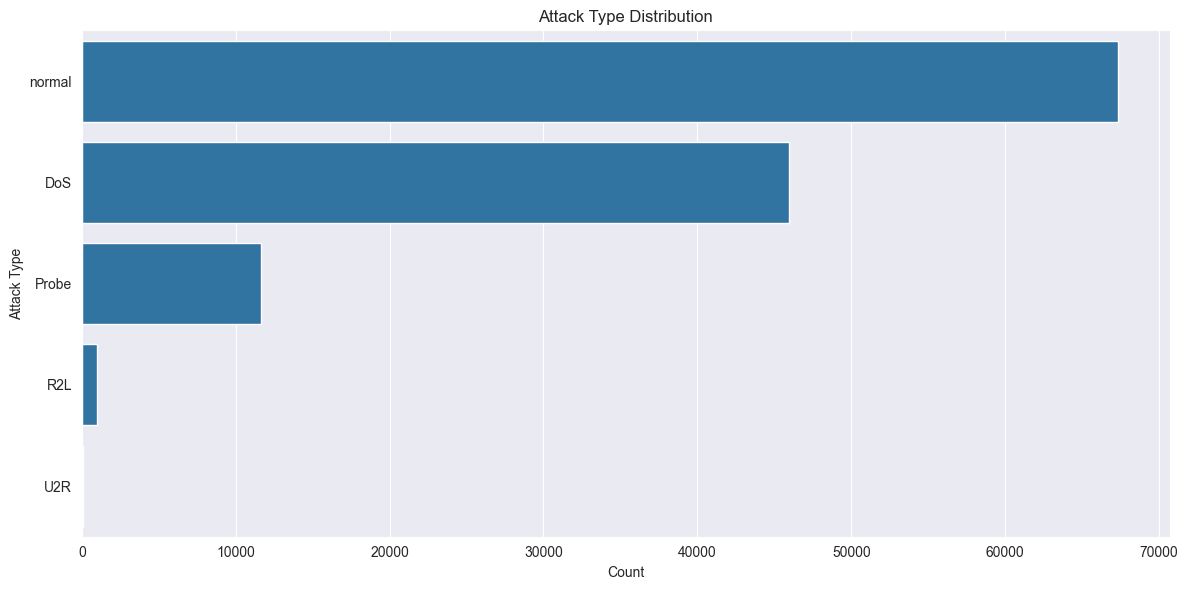

In [10]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='class', data=df, order=class_counts.index)
plt.title('Attack Type Distribution')
plt.xlabel('Count')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.show()

### Binary Features Analysis

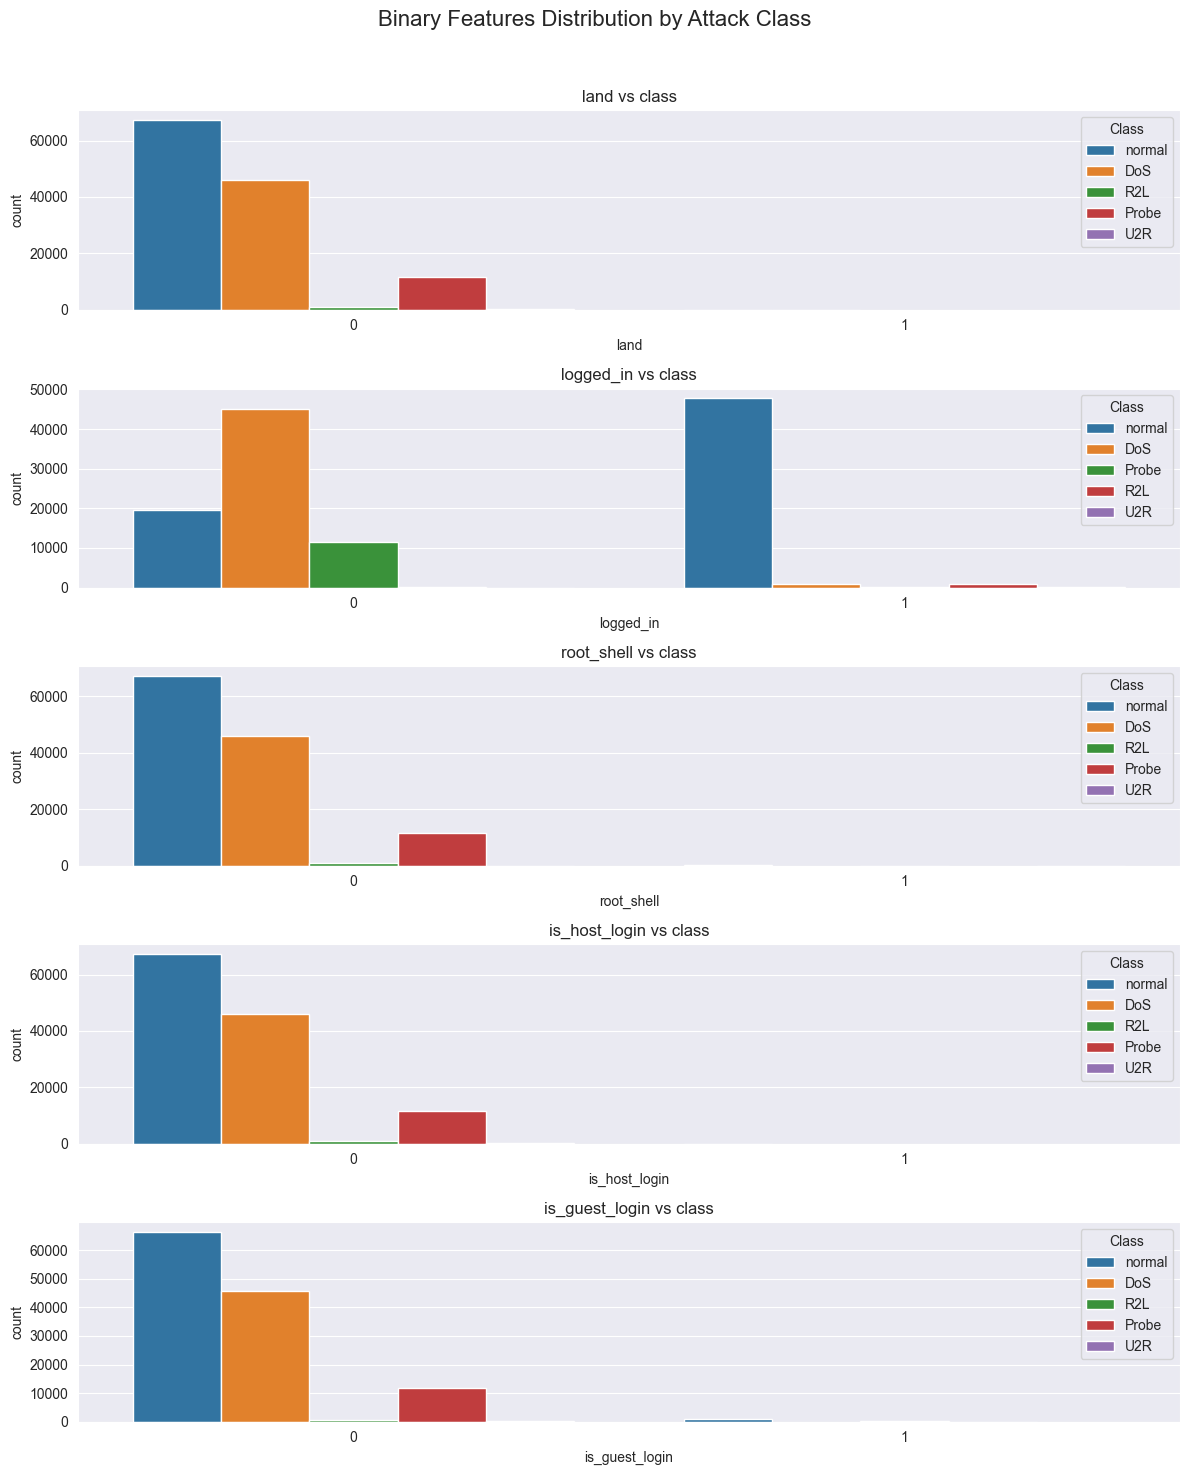

In [11]:
# Explore binary features
binary_cols = ['land', 'logged_in', 'root_shell', 'is_host_login', 'is_guest_login']

# Set up the figure
fig, axes = plt.subplots(len(binary_cols), 1, figsize=(12, 15))
fig.suptitle('Binary Features Distribution by Attack Class', fontsize=16)

# Create plots
for i, col in enumerate(binary_cols):
    sns.countplot(x=col, hue='class', data=df, ax=axes[i])
    axes[i].set_title(f"{col} vs class")
    axes[i].legend(title='Class', loc='upper right')

plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
plt.show()

## Phase 3: Safe Feature Engineering (Before Train-Test Split)



### Remove Constant Features

In [12]:
df = df.drop(columns=['num_outbound_cmds'])

### Convert Data Types

In [13]:
binary_cols = ['land', 'logged_in', 'root_shell', 'is_host_login', 'is_guest_login']
df[binary_cols] = df[binary_cols].astype(int)
print("Binary columns converted to integers")

Binary columns converted to integers


### Create Ratio Features

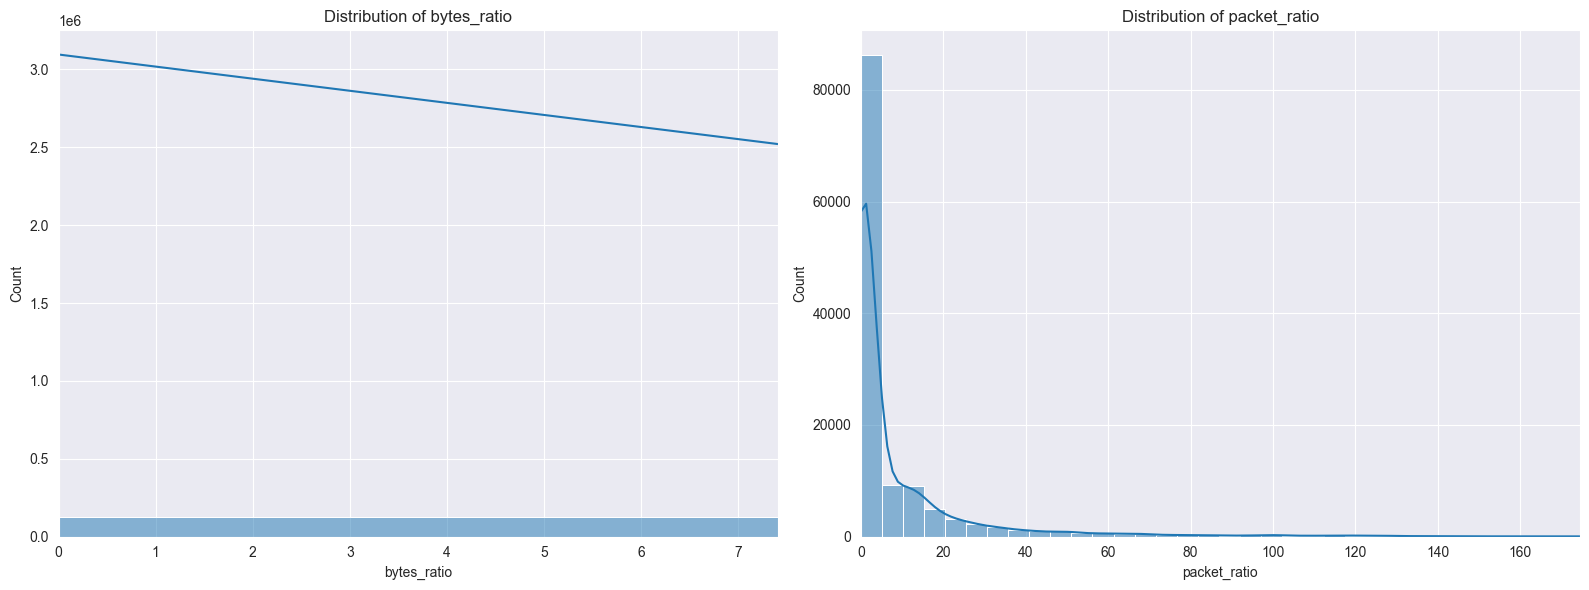

In [14]:
# Create basic ratio features (mathematical transformations are safe)
df['bytes_ratio'] = np.where(df['dst_bytes'] == 0, 0, df['src_bytes'] / (df['dst_bytes'] + 1))
df['packet_ratio'] = np.where(df['srv_count'] == 0, 0, df['count'] / (df['srv_count'] + 1))

# Show the distribution of new ratio features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['bytes_ratio'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution of bytes_ratio')
axes[0].set_xlim([0, df['bytes_ratio'].quantile(0.99)])

sns.histplot(df['packet_ratio'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of packet_ratio')
axes[1].set_xlim([0, df['packet_ratio'].quantile(0.99)])

plt.tight_layout()
plt.show()

### Log Transform Ratio Features

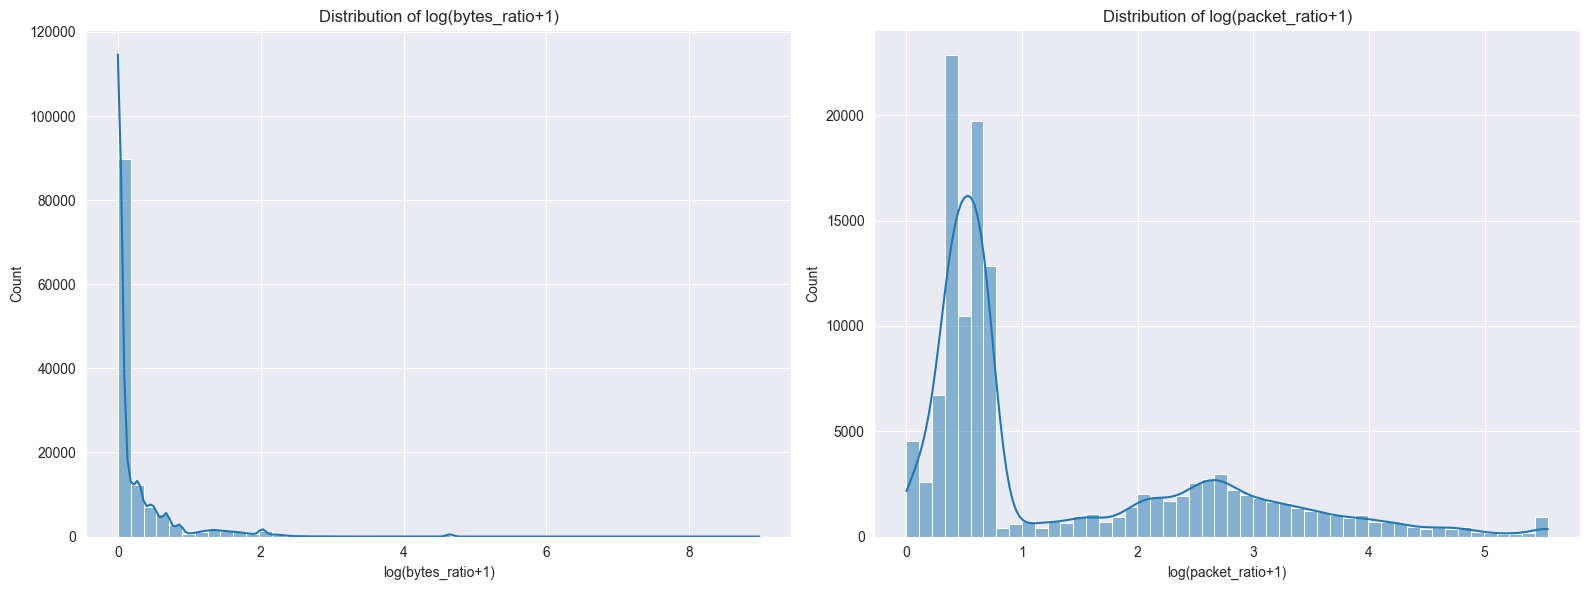

In [15]:
# Log transform ratio features (mathematical transformation is safe)
df['bytes_ratio_log'] = np.log1p(df['bytes_ratio'])
df['packet_ratio_log'] = np.log1p(df['packet_ratio'])

# Visualize the transformed distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df['bytes_ratio_log'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution of log(bytes_ratio+1)')
axes[0].set_xlabel('log(bytes_ratio+1)')

sns.histplot(df['packet_ratio_log'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of log(packet_ratio+1)')
axes[1].set_xlabel('log(packet_ratio+1)')

plt.tight_layout()
plt.show()

# Drop original ratio columns to keep log-transformed versions
df = df.drop(columns=['bytes_ratio', 'packet_ratio'])

### Handle Skewed Features

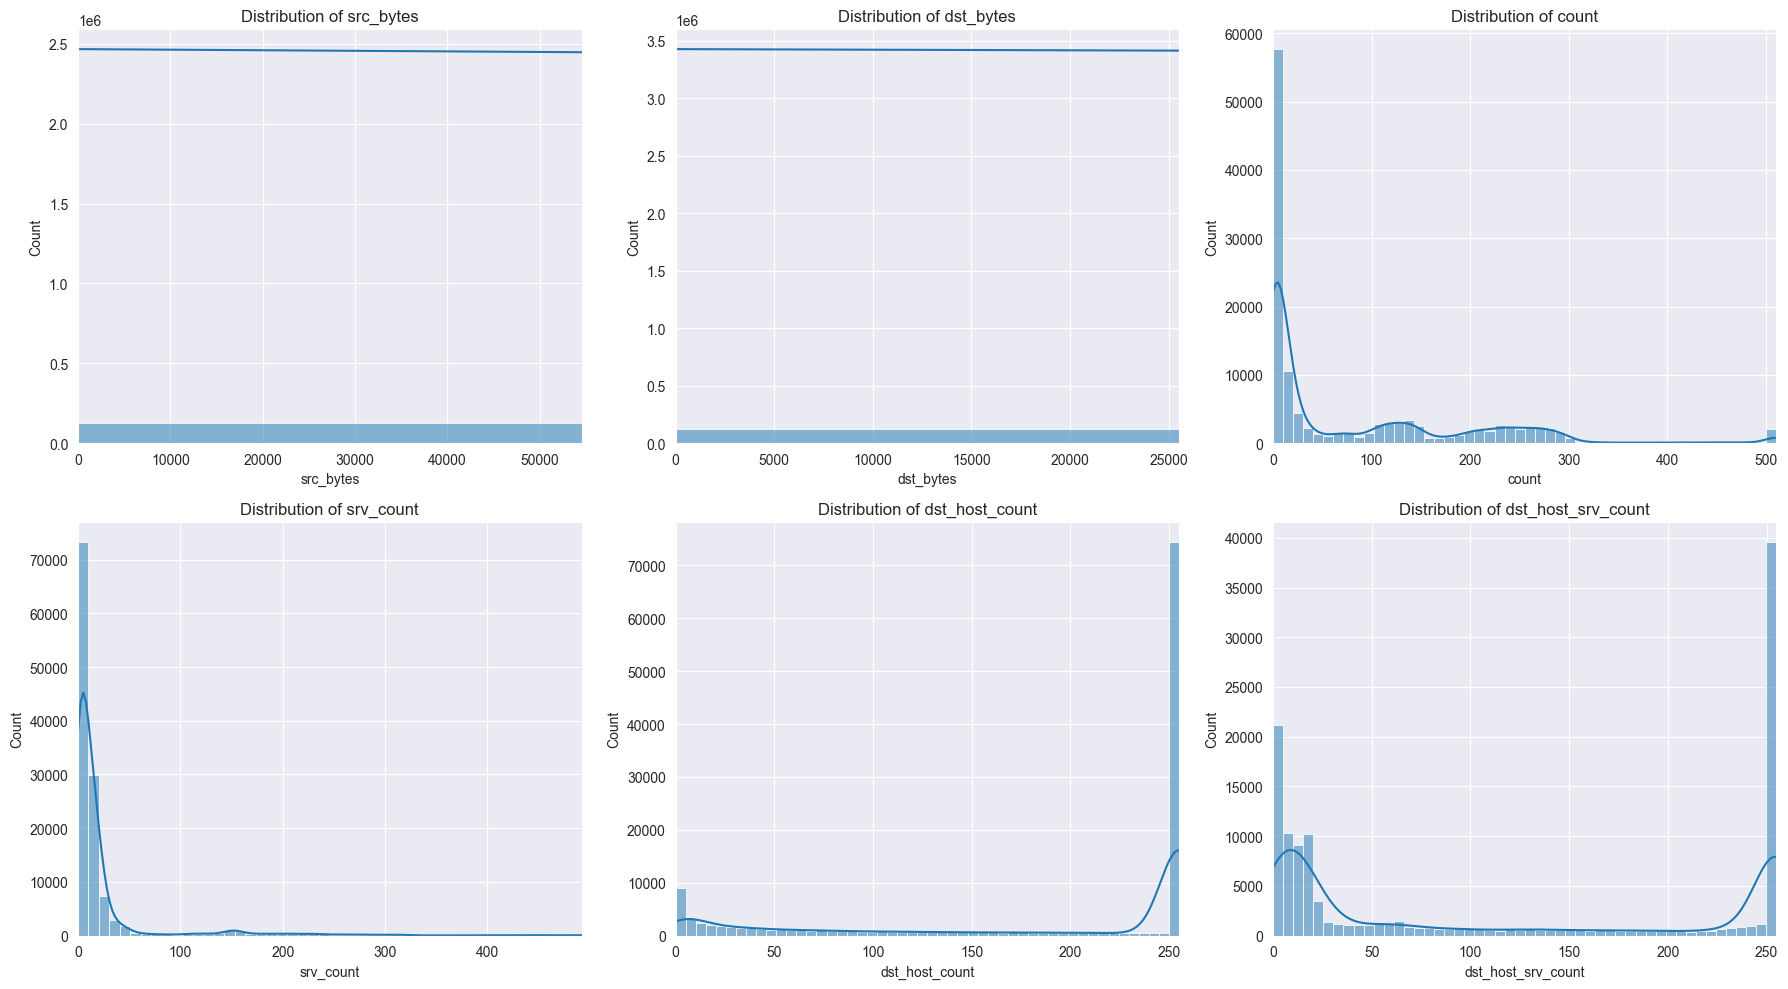

In [16]:
# Identify skewed columns for log transformation
skewed_cols = ['src_bytes', 'dst_bytes', 'count', 'srv_count', 
               'dst_host_count', 'dst_host_srv_count']

# Visualize original distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(skewed_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlim([0, df[col].quantile(0.99)])

plt.tight_layout()
plt.show()

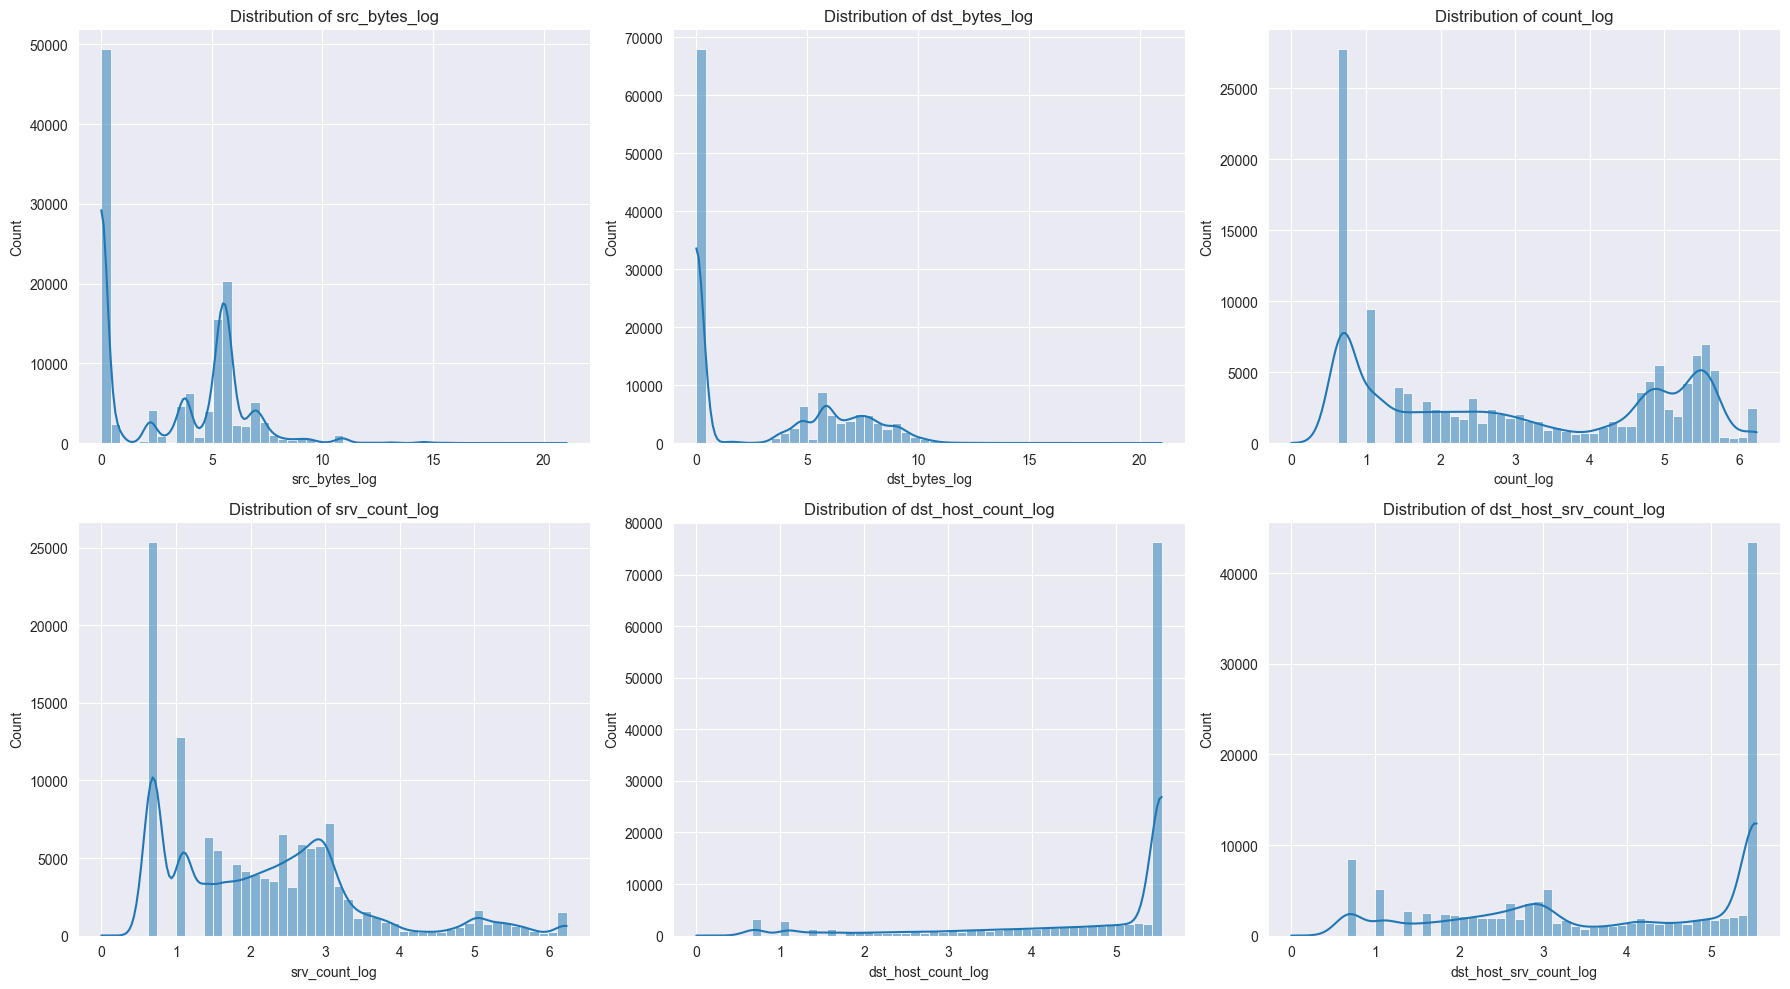

In [17]:
# Apply log transformation to skewed features
for col in skewed_cols:
    df[f'{col}_log'] = np.log1p(df[col])

# Visualize transformed distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(skewed_cols):
    sns.histplot(df[f'{col}_log'], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}_log')

plt.tight_layout()
plt.show()

# Drop original skewed columns
df.drop(columns=skewed_cols, inplace=True)

### Handle Sparse Features

In [18]:
# Identify sparse features for binarization
sparse_cols = ['wrong_fragment', 'urgent', 'num_failed_logins', 
               'num_shells', 'num_access_files']

# Show the distribution of sparse features
for col in sparse_cols:
    print(f"{col} value counts:")
    print(df[col].value_counts())
    print(f"Non-zero percentage: {(df[col] > 0).mean() * 100:.2f}%\n")

wrong_fragment value counts:
wrong_fragment
0    124883
3       884
1       206
Name: count, dtype: int64
Non-zero percentage: 0.87%

urgent value counts:
urgent
0    125964
1         5
2         3
3         1
Name: count, dtype: int64
Non-zero percentage: 0.01%

num_failed_logins value counts:
num_failed_logins
0    125851
1       104
2         9
3         5
4         3
5         1
Name: count, dtype: int64
Non-zero percentage: 0.10%

num_shells value counts:
num_shells
0    125926
1        42
2         5
Name: count, dtype: int64
Non-zero percentage: 0.04%

num_access_files value counts:
num_access_files
0    125602
1       313
2        29
3         8
5         6
4         5
6         4
8         3
7         2
9         1
Name: count, dtype: int64
Non-zero percentage: 0.29%



In [19]:
# Binarize sparse features (mathematical transformation is safe)
for col in sparse_cols:
    df[f'{col}_bin'] = (df[col] > 0).astype(int)

# Drop original sparse columns
df.drop(columns=sparse_cols, inplace=True)

### Correlation

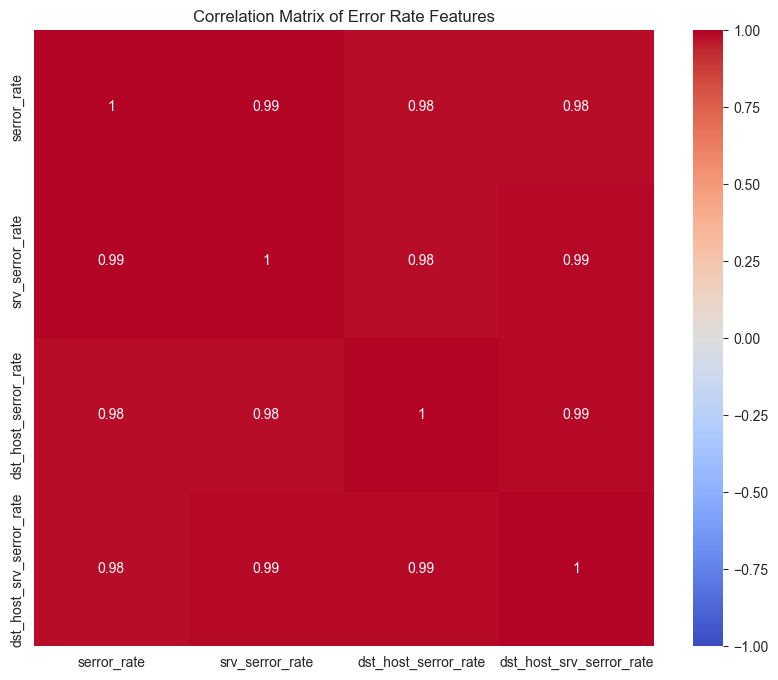

In [20]:
error_features = ['serror_rate', 'srv_serror_rate',
                 'dst_host_serror_rate', 'dst_host_srv_serror_rate']
error_corr = df[error_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(error_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Error Rate Features')
plt.show()

In [21]:
# Analyze service column for later frequency encoding
print(f"Number of unique services: {df['service'].nunique()}")
top_services = df['service'].value_counts().head(10)
print("Top 10 services:")
print(top_services)

Number of unique services: 70
Top 10 services:
service
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
eco_i        4586
other        4359
ecr_i        3077
telnet       2353
finger       1767
Name: count, dtype: int64


### Final Cleanup

In [22]:
if 'data' in df.columns:
    df.drop(columns=['data'], inplace=True)
df.head()

,duration,protocol_type,service,flag,land,hot,logged_in,num_compromised,root_shell,su_attempted,...,dst_bytes_log,count_log,srv_count_log,dst_host_count_log,dst_host_srv_count_log,wrong_fragment_bin,urgent_bin,num_failed_logins_bin,num_shells_bin,num_access_files_bin
0,0,tcp,ftp_data,SF,0,0,0,0,0,0,...,0.000000,1.098612,1.098612,5.017280,3.258097,0,0,0,0,0
1,0,udp,other,SF,0,0,0,0,0,0,...,0.000000,2.639057,0.693147,5.545177,0.693147,0,0,0,0,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.000000,4.820282,1.945910,5.545177,3.295837,0,0,0,0,0
3,0,tcp,http,SF,0,0,1,0,0,0,...,9.006264,1.791759,1.791759,3.433987,5.545177,0,0,0,0,0
4,0,tcp,http,SF,0,0,1,0,0,0,...,6.042633,3.433987,3.496508,5.545177,5.545177,0,0,0,0,0


## Phase 4: Target Preparation and Train-Test Split



In [23]:

y = df['class']
X = df.drop(columns=['class'])

# Convert to numeric classes
le = LabelEncoder()
y_numeric = le.fit_transform(y)
print("Class encoding:")
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")

Class encoding:
DoS: 0
Probe: 1
R2L: 2
U2R: 3
normal: 4


### Data split

In [24]:
# SPLIT DATA FIRST - This is the key fix!
X_train, X_test, y_train, y_test = train_test_split(
    X, y_numeric, test_size=0.3, random_state=42, stratify=y_numeric
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 88181 samples
Test set: 37792 samples


## Phase 5: Learning-Based Transformations (After Split)

**✅ Now it's safe to apply transformations that learn from data - but only fit on training data!**

### Handle Categorical Features

In [25]:
# Now apply transformations that require learning - ONLY on training data

# 1. Handle categorical columns - One-hot encode
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns: {cat_cols}")

# One-hot encode training data
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True, dtype=int)

# For test data, we need to ensure same columns exist
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True, dtype=int)

# Align columns between train and test (important!)
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0

extra_cols = set(X_test_encoded.columns) - set(X_train_encoded.columns)
for col in extra_cols:
    X_train_encoded[col] = 0

# Reorder columns to match
X_test_encoded = X_test_encoded[X_train_encoded.columns]

print(f"Shape after encoding - Train: {X_train_encoded.shape}, Test: {X_test_encoded.shape}")

Categorical columns: ['protocol_type', 'service', 'flag']
Shape after encoding - Train: (88181, 120), Test: (37792, 120)


### Scale Features

In [26]:
# 2. Scale features - fit scaler only on training data
scale_cols = ['duration', 'hot', 'num_compromised']

scale_cols = [col for col in scale_cols if col in X_train_encoded.columns]

if scale_cols:
    scaler = StandardScaler()
    X_train_encoded[scale_cols] = scaler.fit_transform(X_train_encoded[scale_cols])
    X_test_encoded[scale_cols] = scaler.transform(X_test_encoded[scale_cols])  # Use transform, not fit_transform!
    print(f"Scaled columns: {scale_cols}")

Scaled columns: ['duration', 'hot', 'num_compromised']


### Apply PCA

In [27]:
# 3. Apply PCA to error features - fit only on training data
error_features = [col for col in error_features if col in X_train_encoded.columns]

if error_features:
    pca = PCA(n_components=1)
    X_train_encoded['error_pca'] = pca.fit_transform(X_train_encoded[error_features])
    X_test_encoded['error_pca'] = pca.transform(X_test_encoded[error_features])  # Use transform, not fit_transform!
    
    explained_var = pca.explained_variance_ratio_[0]
    print(f"PCA for error features explains {explained_var:.2%} of variance")
    
    # Drop original error features
    X_train_encoded = X_train_encoded.drop(columns=error_features)
    X_test_encoded = X_test_encoded.drop(columns=error_features)

PCA for error features explains 98.80% of variance


### Feature Selection

In [28]:
# 4. Feature selection - fit only on training data
selector = SelectKBest(score_func=f_classif, k=20)  # Select top 20 features
X_train_selected = selector.fit_transform(X_train_encoded, y_train)
X_test_selected = selector.transform(X_test_encoded)  # Use transform, not fit_transform!

# Get selected feature names
selected_features = X_train_encoded.columns[selector.get_support()]
print(f"Selected {len(selected_features)} features:")
print(selected_features.tolist())

# Convert back to DataFrame for easier handling
X_train_final = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_final = pd.DataFrame(X_test_selected, columns=selected_features)

Selected 20 features:
['logged_in', 'same_srv_rate', 'diff_srv_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'packet_ratio_log', 'src_bytes_log', 'dst_bytes_log', 'count_log', 'dst_host_count_log', 'dst_host_srv_count_log', 'service_eco_i', 'service_http', 'service_private', 'flag_RSTR', 'flag_S0', 'flag_SF', 'error_pca']


C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [115] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


## Phase 6: Handle Class Imbalance

### Apply SMOTE

In [29]:
# Check class distribution before SMOTE
print("Training set class distribution before SMOTE:")
print(pd.Series(y_train).value_counts())

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train)

print("\nTraining set class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Training set class distribution before SMOTE:
4    47140
0    32149
1     8159
2      697
3       36
Name: count, dtype: int64

Training set class distribution after SMOTE:
4    47140
0    47140
1    47140
2    47140
3    47140
Name: count, dtype: int64


### Create Different Training Set Sizes

In [30]:
# Create different sized training sets
X_train_30, _, y_train_30, _ = train_test_split(
    X_train_resampled, y_train_resampled,
    train_size=0.3,
    stratify=y_train_resampled,
    random_state=42
)

X_train_60, _, y_train_60, _ = train_test_split(
    X_train_resampled, y_train_resampled,
    train_size=0.6,
    stratify=y_train_resampled,
    random_state=42
)

## Phase 7: Save Processed Datasets

### Export Final Datasets

In [31]:
# Save datasets
pd.DataFrame(X_train_30).to_csv('X_train_30.csv', index=False)
pd.DataFrame(y_train_30).to_csv('y_train_30.csv', index=False)

pd.DataFrame(X_train_60).to_csv('X_train_60.csv', index=False)
pd.DataFrame(y_train_60).to_csv('y_train_60.csv', index=False)

pd.DataFrame(X_train_resampled).to_csv('X_train_100.csv', index=False)
pd.DataFrame(y_train_resampled).to_csv('y_train_100.csv', index=False)

# Save test set (this remains the same for all experiments)
pd.DataFrame(X_test_final).to_csv('X_test.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)

### Verify Final Results

In [32]:
# Verify final shapes
print("Final dataset shapes:")
print(f"X_train_30: {X_train_30.shape}")
print(f"X_train_60: {X_train_60.shape}")
print(f"X_train_resampled: {X_train_resampled.shape}")
print(f"X_test_final: {X_test_final.shape}")
print(f"All y shapes: {len(y_train_30)}, {len(y_train_60)}, {len(y_train_resampled)}, {len(y_test)}")



Final dataset shapes:
X_train_30: (70710, 20)
X_train_60: (141420, 20)
X_train_resampled: (235700, 20)
X_test_final: (37792, 20)
All y shapes: 70710, 141420, 235700, 37792


NameError: name 'y_test' is not defined